In [1]:
import mlrun

In [2]:
# nuclio: ignore
import nuclio

In [3]:
import os
import json
import importlib
from cloudpickle import load

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import TableArtifact, PlotArtifact

from mlrun.mlutils import plot_roc, plot_importance, gcf_clear

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


def test_classifier(
    context: MLClientCtx,
    models_path: str, 
    test_set: str,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = ""
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     artifact models representing a file or a folder
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:       dir for test plots
    """
    xtest = pd.read_parquet(str(test_set))
    ytest = xtest.pop(label_column)
    
    context.header = list(xtest.columns.values)
    def _eval_model(model):
        # enclose all except model
        ytestb = label_binarize(ytest, classes=ytest.unique())
        clf = load(open(model, "rb"))
        if callable(getattr(clf, "predict_proba")):
            y_score = clf.predict_proba(xtest.values)
            ypred = clf.predict(xtest.values)
            plot_roc(context, ytestb, y_score, key='roc', plots_dir=plots_dest)
        else:
            ypred = clf.predict(xtest.values) # refactor
            y_score = None
            
        gcf_clear(plt)
        metrics.plot_confusion_matrix(clf, xtest.values, ytest, 
                                      labels=ytest.unique(), normalize='true') 
        
        context.log_artifact(PlotArtifact("confusion", body=plt.gcf()), 
                             local_path=f"{plots_dest}/confusion.html")        
    
        if hasattr(clf, "feature_importances_"):
            plot_importance(context, clf, key=f"featimp")

        ytestb = label_binarize(ytest, classes=ytest.unique())

        if ytestb.shape[1] > 1:
            average_precision = metrics.average_precision_score(ytestb,
                                                                y_score,
                                                                average=score_method)
            context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score))
        else:
            average_precision = metrics.average_precision_score(ytestb,
                                                                y_score[:, 1],
                                                                average=score_method)
            context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score[:, 1]))

        context.log_result(f"avg_precscore", average_precision)
        context.log_result(f"accuracy", float(clf.score(xtest.values, ytest)))
        context.log_result(f"f1_score", metrics.f1_score(ytest, ypred,
                                                         average=score_method))
        if y_score is None:
            return y_score
        else:
            return ypred
    
    models_path = str(models_path)
    for model in os.listdir(models_path):
        if model.endswith('.pkl'):
            y_hat = _eval_model(os.path.join(models_path, model))
            if y_hat.ndim == 1 or y_hat.shape[1] == 1:
                score_names = ["yscore"]
            else:
                score_names = ["yscore_" + str(x) for x in range(y_hat.shape[1])]
            df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
            context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [4]:
# nuclio: end-code

### mlconfig

In [5]:
from mlrun import mlconf

In [6]:
mlconf.dbpath = mlconf.dbpath or './'
mlconf.dbpath

'http://mlrun-api:8080'

In [7]:
vcs_branch = 'development'
base_vcs = f'https://raw.githubusercontent.com/mlrun/functions/{vcs_branch}/'

mlconf.hub_url = mlconf.hub_url or base_vcs + f'{name}/function.yaml'
mlconf.hub_url

'/User/repos/functions/{name}/function.yaml'

In [8]:
import os
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["V3IO_HOME"]}/artifacts'
mlconf.artifact_path

'/User/artifacts'

### save

In [9]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier", kind="job", with_doc=True,
                      image="mlrun/ml-models:0.4.6")

# add metadata (for templates and reuse)
fn.spec.default_handler = "test_classifier"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["models", "testing"]
fn.metadata.labels = {"author": "yjb"}

fn.save()
fn.export("function.yaml")

[mlrun] 2020-04-25 22:59:31,310 saving function: test-classifier, tag: latest
[mlrun] 2020-04-25 22:59:31,345 function spec saved to path: function.yaml


## tests

In [10]:
from mlrun import import_function

func = import_function("hub://test_classifier")

if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    func.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    func.apply(mount_pvc('nfsvol', 'nfsvol', '/home/joyan/data'))

In [11]:
task_params = {
    "name" : "tasks - test classifier",
    "params": {
        # Ina pipeline setting, the models_path parameter would be the output of a training step
        "models_path"   : "/User/artifacts/models",
        "label_column"  : "labels"}}

### run locally

[mlrun] 2020-04-25 22:59:31,399 starting run tasks - test classifier uid=852de1f52005496a93848928722a0631  -> http://mlrun-api:8080


No handles with labels found to put in legend.


[mlrun] 2020-04-25 22:59:32,029 log artifact roc at /User/artifacts/roc.html, size: 20310, db: Y
[mlrun] 2020-04-25 22:59:32,167 log artifact confusion at /User/artifacts/confusion.html, size: 10924, db: Y
[mlrun] 2020-04-25 22:59:32,526 log artifact test_set_preds at /User/artifacts/test_set_preds.parquet, size: 6289138, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...722a0631,0,Apr 25 22:59:31,completed,tasks - test classifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-5859859b4f-hwhxd,test_set,models_path=/User/artifacts/modelslabel_column=labels,rocauc=0.9202522737874301avg_precscore=0.8728482380553134accuracy=0.842f1_score=0.842,rocconfusiontest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 852de1f52005496a93848928722a0631 --project default , !mlrun logs 852de1f52005496a93848928722a0631 --project default
[mlrun] 2020-04-25 22:59:32,657 run executed, status=completed


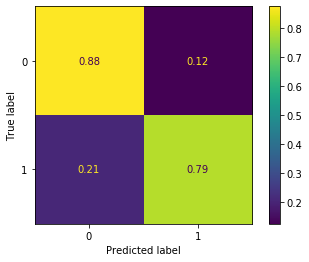

In [12]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set":"test_set.parquet" },
                workdir="/User/artifacts/",
                artifact_path="/User/artifacts")

In [13]:
pd.read_parquet('/User/artifacts/test_set_preds.parquet').head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,labels,yscore
0,-1.074282,0.292997,-0.110986,-0.452311,-5.016057,-0.683376,0.906051,0.497374,1.067571,-2.275444,...,0.286225,-1.440201,-2.541867,-0.839610,0.315956,-0.165894,0.116199,1.334966,0,0
1,1.422231,1.765523,1.346516,0.753744,0.290271,0.965437,1.539053,0.702123,0.128408,0.424845,...,1.387546,-1.783310,-1.392866,-1.251982,-0.716217,1.099336,-0.040071,-1.132424,1,1
2,0.367283,1.661197,1.451230,-0.492931,1.840647,0.461539,0.744171,-1.246005,-0.044902,0.711336,...,-1.019190,1.917711,-6.105805,1.573529,1.431084,1.550312,2.133927,-0.823332,0,0
3,-0.178263,3.468529,0.524846,0.095893,-1.606518,0.449954,-1.252561,-0.674343,0.103801,0.278392,...,0.963217,0.750422,-1.281318,-1.306262,1.236454,0.612190,-0.151385,-0.998545,1,1
4,-2.880236,3.796778,-0.091107,0.865462,0.696080,1.156626,0.555431,1.130077,-1.385785,0.248752,...,-0.576093,-0.920981,-3.236707,0.657426,-0.505787,-0.355300,-1.080203,0.402828,1,1


### remotely

In [14]:
from mlrun import NewTask
run = func.run(NewTask(**task_params), 
               inputs={"test_set":"test_set.parquet" },
               workdir="/User/artifacts",
               artifact_path="/User/artifacts")

[mlrun] 2020-04-25 22:59:32,820 starting run tasks - test classifier uid=5c46b66d7364498bb22475f2fb397277  -> http://mlrun-api:8080
[mlrun] 2020-04-25 22:59:32,920 Job is running in the background, pod: tasks---test-classifier-487hb
No handles with labels found to put in legend.
[mlrun] 2020-04-25 22:59:37,691 log artifact roc at /User/artifacts/roc.html, size: 38290, db: Y
[mlrun] 2020-04-25 22:59:37,881 log artifact confusion at /User/artifacts/confusion.html, size: 20688, db: Y
[mlrun] 2020-04-25 22:59:38,193 log artifact test_set_preds at /User/artifacts/test_set_preds.parquet, size: 6287015, db: Y

[mlrun] 2020-04-25 22:59:38,288 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...fb397277,0,Apr 25 22:59:37,completed,tasks - test classifier,host=tasks---test-classifier-487hbkind=jobowner=adminv3io_user=admin,test_set,label_column=labelsmodels_path=/User/artifacts/models,accuracy=0.842avg_precscore=0.8728482380553134f1_score=0.842rocauc=0.9202522737874301,rocconfusiontest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 5c46b66d7364498bb22475f2fb397277  , !mlrun logs 5c46b66d7364498bb22475f2fb397277 
[mlrun] 2020-04-25 22:59:39,324 run executed, status=completed
